## 0. Import Libraries

In [2]:
from datetime import datetime, timedelta
from glob import glob

import numpy as np
import pandas as pd
import pyproj
import rioxarray
import matplotlib
import salem
import xarray as xr
from shapely.geometry import mapping

import cartopy
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import proplot
from matplotlib.colors import BoundaryNorm, ListedColormap
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from dea_tools.spatial import xr_vectorize, xr_rasterize
from wrf import getvar, interpline, CoordPair, xy_to_ll, ll_to_xy 

import warnings
warnings.filterwarnings('ignore')

## 1. Open Data

### 1.1 ERA5

#### 1.1.1 T2C

In [3]:
run_data = 'era5'
variable = 'T2C'
general_path = 'data'

# ensemble members
micro_options = [
    'LIN',
    'THOMPSON',
    'WSM6'
]

luse_options = [
    'urban',
    'nourban'
]

# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}*')

In [4]:
data_path

['data/era5_LIN_nourban_T2C_wrfout_d03_2017-07-17.nc',
 'data/era5_LIN_urban_T2C_wrfout_d03_2017-07-17.nc',
 'data/era5_THOMPSON_nourban_T2C_wrfout_d03_2017-07-17.nc',
 'data/era5_THOMPSON_urban_T2C_wrfout_d03_2017-07-17.nc',
 'data/era5_WSM6_nourban_T2C_wrfout_d03_2017-07-17.nc',
 'data/era5_WSM6_urban_T2C_wrfout_d03_2017-07-17.nc']

In [5]:
# open data
dt_t2c_era5 = xr.open_mfdataset(data_path,
                       concat_dim='ens').isel(time=slice(18,21))[variable]

# ensemble member list
ensemble_members = list(dt_t2c_era5.ens.values)

# urban and nourban members
urban_members = [ens for ens in ensemble_members if not 'nourban' in ens ]
nourban_members = [ens for ens in ensemble_members if 'nourban' in ens ]

dt_t2c_era5_urban_ens = dt_t2c_era5.sel(ens=urban_members).mean(dim='ens').mean(dim='time')
dt_t2c_era5_nourban_ens = dt_t2c_era5.sel(ens=nourban_members).mean(dim='ens').mean(dim='time')
dt_t2c_era5_diff = dt_t2c_era5_urban_ens - dt_t2c_era5_nourban_ens

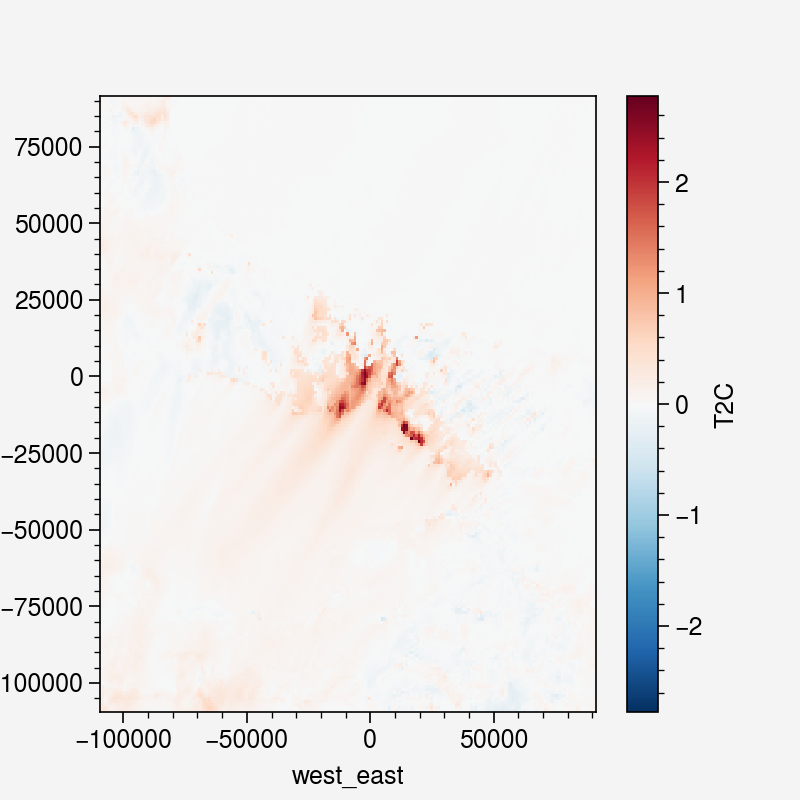

In [6]:
dt_t2c_era5_diff.plot()

#### 1.1.2 Surface H

In [7]:
run_data = 'era5'
variable = 'ACHFX'
general_path = 'data'

# ensemble members
micro_options = [
    'LIN',
    'THOMPSON',
    'WSM6'
]

luse_options = [
    'urban',
    'nourban'
]

# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}*')

In [8]:
data_path

['data/era5_LIN_nourban_ACHFX_wrfout_d03_2017-07-17.nc',
 'data/era5_LIN_urban_ACHFX_wrfout_d03_2017-07-17.nc',
 'data/era5_THOMPSON_nourban_ACHFX_wrfout_d03_2017-07-17.nc',
 'data/era5_THOMPSON_urban_ACHFX_wrfout_d03_2017-07-17.nc',
 'data/era5_WSM6_nourban_ACHFX_wrfout_d03_2017-07-17.nc',
 'data/era5_WSM6_urban_ACHFX_wrfout_d03_2017-07-17.nc']

In [9]:
# open data
dt_h_era5 = xr.open_mfdataset(data_path,
                       concat_dim='ens').isel(time=slice(18,21))[variable]

# ensemble member list
ensemble_members = list(dt_h_era5.ens.values)

# urban and nourban members
urban_members = [ens for ens in ensemble_members if not 'nourban' in ens ]
nourban_members = [ens for ens in ensemble_members if 'nourban' in ens ]

dt_h_era5_urban_ens = dt_h_era5.sel(ens=urban_members).mean(dim='ens').mean(dim='time')
dt_h_era5_nourban_ens = dt_h_era5.sel(ens=nourban_members).mean(dim='ens').mean(dim='time')
dt_h_era5_diff = dt_h_era5_urban_ens - dt_h_era5_nourban_ens

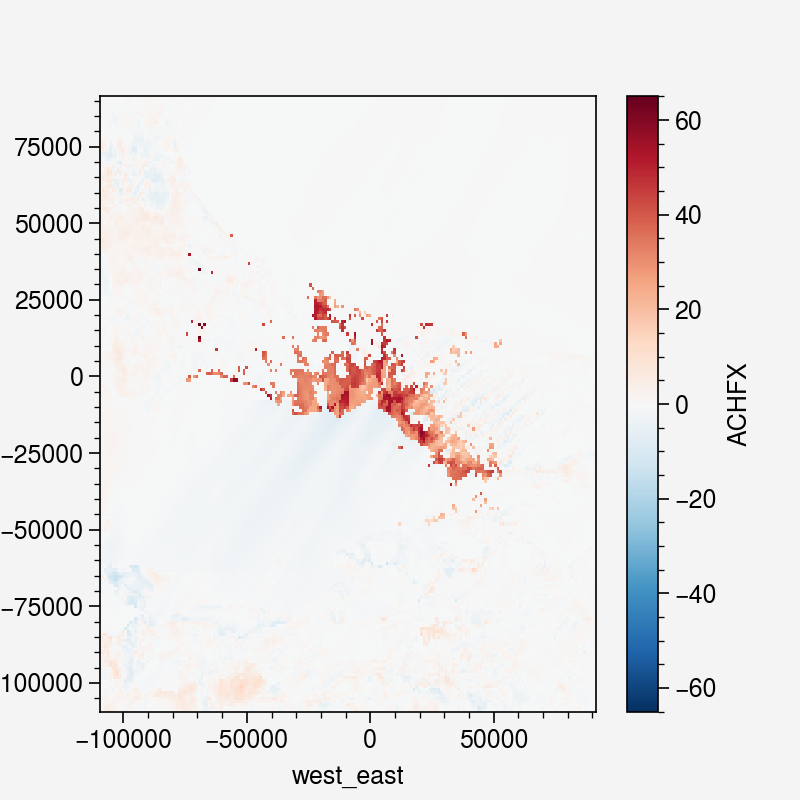

In [10]:
dt_h_era5_diff.plot()

### 1.2 GFS

#### 1.2.1 T2C

In [11]:
run_data = 'gfs'
variable = 'T2C'
general_path = 'data'

# ensemble members
micro_options = [
    'LIN',
    'THOMPSON',
    'WSM6'
]

luse_options = [
    'urban',
    'nourban'
]

# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}*')

In [12]:
data_path

['data/gfs_LIN_nourban_T2C_wrfout_d03_2017-07-17.nc',
 'data/gfs_LIN_urban_T2C_wrfout_d03_2017-07-17.nc',
 'data/gfs_THOMPSON_nourban_T2C_wrfout_d03_2017-07-17.nc',
 'data/gfs_THOMPSON_urban_T2C_wrfout_d03_2017-07-17.nc',
 'data/gfs_WSM6_nourban_T2C_wrfout_d03_2017-07-17.nc',
 'data/gfs_WSM6_urban_T2C_wrfout_d03_2017-07-17.nc']

In [13]:
# open data
dt_t2c_gfs = xr.open_mfdataset(data_path,
                       concat_dim='ens').isel(time=slice(18,21))[variable]

# ensemble member list
ensemble_members = list(dt_t2c_gfs.ens.values)

# urban and nourban members
urban_members = [ens for ens in ensemble_members if not 'nourban' in ens ]
nourban_members = [ens for ens in ensemble_members if 'nourban' in ens ]

dt_t2c_gfs_urban_ens = dt_t2c_gfs.sel(ens=urban_members).mean(dim='ens').mean(dim='time')
dt_t2c_gfs_nourban_ens = dt_t2c_gfs.sel(ens=nourban_members).mean(dim='ens').mean(dim='time')
dt_t2c_gfs_diff = dt_t2c_gfs_urban_ens - dt_t2c_gfs_nourban_ens

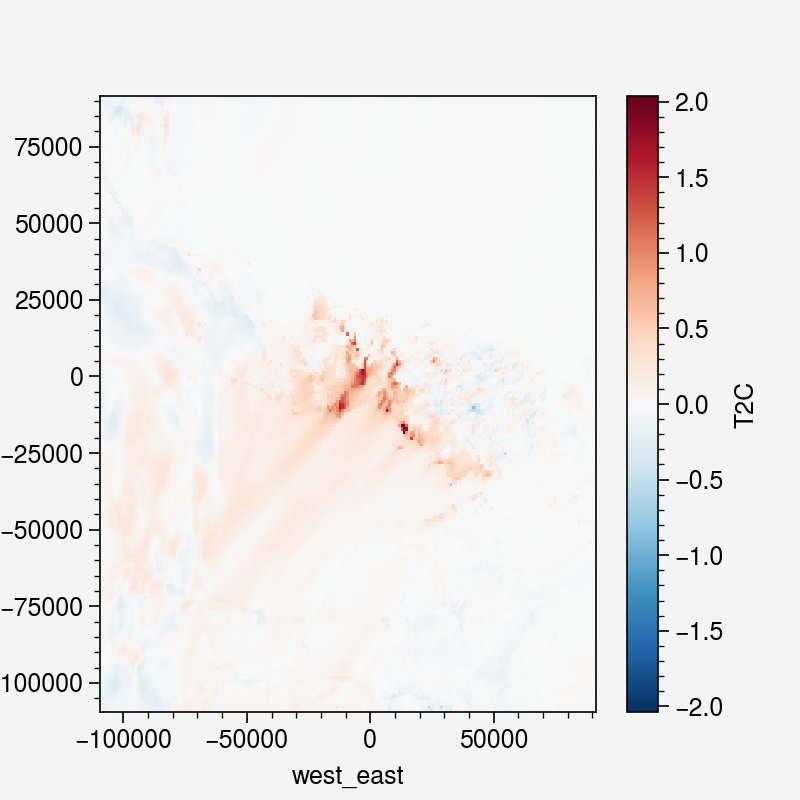

In [14]:
dt_t2c_gfs_diff.plot()

#### 1.2.2 Surface H

In [15]:
run_data = 'gfs'
variable = 'ACHFX'
general_path = 'data'

# ensemble members
micro_options = [
    'LIN',
    'THOMPSON',
    'WSM6'
]

luse_options = [
    'urban',
    'nourban'
]

# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}*')

In [16]:
data_path

['data/gfs_LIN_nourban_ACHFX_wrfout_d03_2017-07-17.nc',
 'data/gfs_LIN_urban_ACHFX_wrfout_d03_2017-07-17.nc',
 'data/gfs_THOMPSON_nourban_ACHFX_wrfout_d03_2017-07-17.nc',
 'data/gfs_THOMPSON_urban_ACHFX_wrfout_d03_2017-07-17.nc',
 'data/gfs_WSM6_nourban_ACHFX_wrfout_d03_2017-07-17.nc',
 'data/gfs_WSM6_urban_ACHFX_wrfout_d03_2017-07-17.nc']

In [17]:
# open data
dt_h_gfs = xr.open_mfdataset(data_path,
                       concat_dim='ens').isel(time=slice(18,21))[variable]

# ensemble member list
ensemble_members = list(dt_h_gfs.ens.values)

# urban and nourban members
urban_members = [ens for ens in ensemble_members if not 'nourban' in ens ]
nourban_members = [ens for ens in ensemble_members if 'nourban' in ens ]

dt_h_gfs_urban_ens = dt_h_gfs.sel(ens=urban_members).mean(dim='ens').mean(dim='time')
dt_h_gfs_nourban_ens = dt_h_gfs.sel(ens=nourban_members).mean(dim='ens').mean(dim='time')
dt_h_gfs_diff = dt_h_gfs_urban_ens - dt_h_gfs_nourban_ens

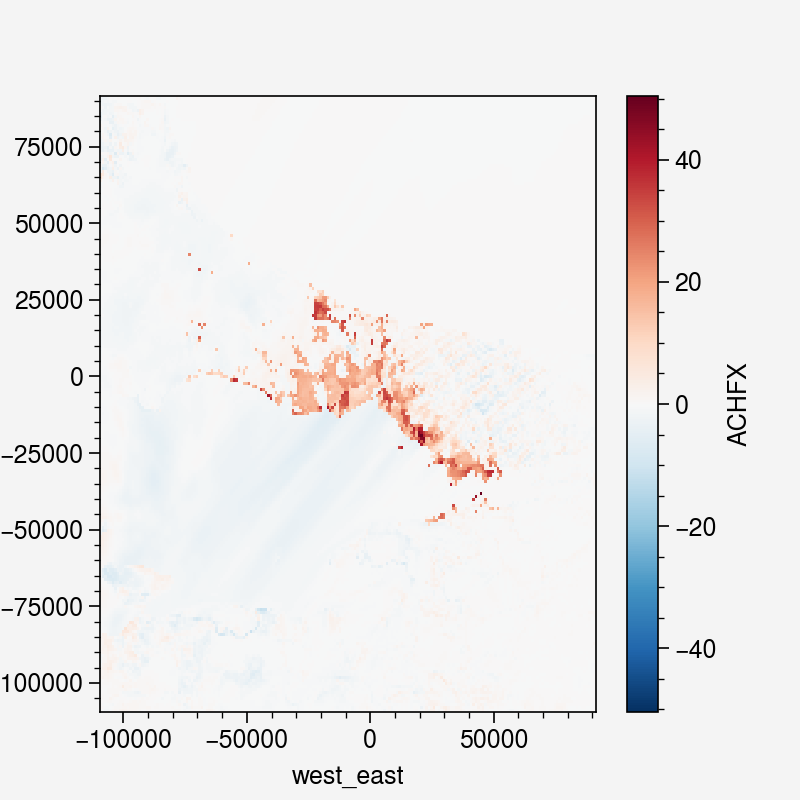

In [18]:
dt_h_gfs_diff.plot()

### 1.3 Extra Datasets

In [19]:
proj_data = xr.open_dataset(r'data/era5_lin_urban_PRCP_wrfout_d03_2017-07-18.nc')['PRCP']
# assign projection and dim info
proj_data = proj_data.rio.write_crs(proj_data.attrs['pyproj_srs'])
proj_data = proj_data.rio.set_spatial_dims(x_dim='west_east',
                             y_dim='south_north')

## 2. Plot

In [20]:
# add shapefiles
turkey_district_shape = r'data/shapefiles/istanbul_province_borders.shp'
turkey_province_shape = r'data/shapefiles/Iller_HGK_6360_Kanun_Sonrasi.shp'

In [21]:
luse_var = 'LU_INDEX'
urban_luse_border = xr.open_dataset(fr'{general_path}/wrfout_d03_LU_INDEX_urban.nc')[luse_var]
urban_luse_border = urban_luse_border.where(urban_luse_border==1, 0).isel(west_east = slice(35, 162),
                                                                               south_north = slice(57, 157))

In [22]:
# Parameters to change (plot) -------------------

# projection
proj = proj_data.rio.crs.to_dict()
globe = cartopy.crs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
lcc = cartopy.crs.LambertConformal(globe=globe, # important!
                            central_longitude=proj['lon_0'], 
                            central_latitude=proj['lat_0'],
                            standard_parallels=(proj['lat_1'], proj['lat_2']),
                            )

# fig features
fig_array = [[1,2],
             [3,4],
            ]
graphic_no = 4


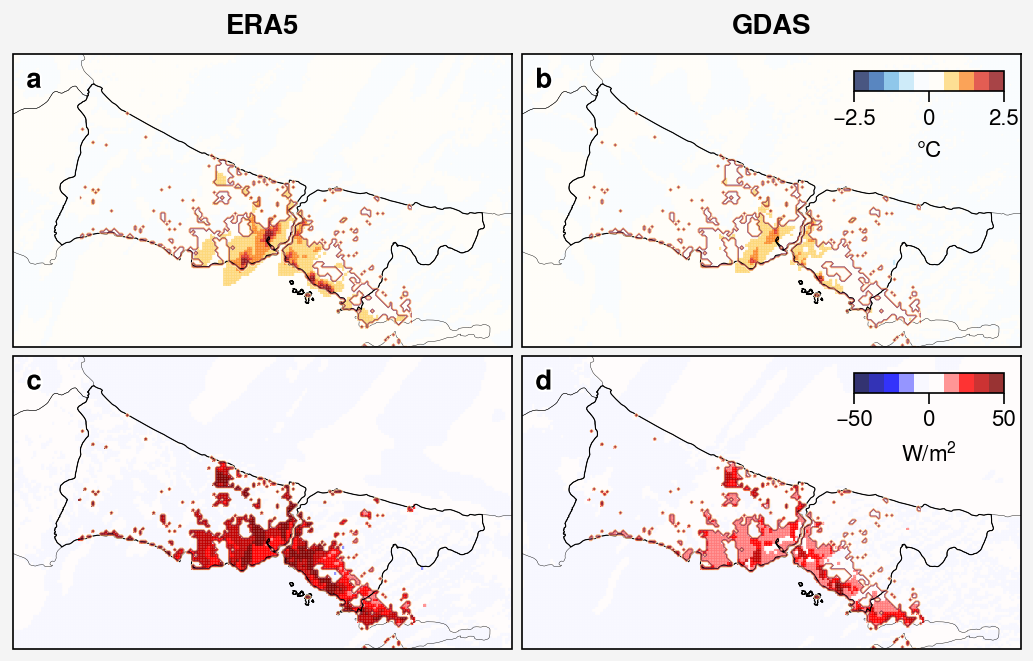

In [23]:
# Create Figure -------------------------
fig2, axs2 = proplot.subplots(fig_array, 
                            proj=[lcc, lcc, lcc, lcc],#, None, None, None, None],
                            includepanels=True,
                            hspace=0.36,
                            wspace=0.36,
                            span=True,
                            sharex=4,
                            sharey=4
                             )

# format whole figure
axs2.format(abcloc='ul',
           abc=True,
            )

# istanbul urban limits
lonlim=(27.69171143+0.10, 30.04271274)
latlim=(40.08444595+0.60, 41.88309609-0.20)

range_2d = [0,1,2,3]
for i in range_2d:
    axs2[i].format(lonlim=lonlim, 
               latlim=latlim,
               labels=False, 
               longrid=False, 
               latgrid = False)
    
axs2.format(collabels=['ERA5', 'GDAS']
           )

#for i in [6,7,8,9]:
#    axs2[i].format(grid=False)
    
# 2D PLOTS

# add shapefiles
turkey_district_shape = r'data/shapefiles/istanbul_province_borders.shp'
shape_district_turkey = ShapelyFeature(Reader(turkey_district_shape).geometries(),
                                             cartopy.crs.PlateCarree(), facecolor='none',
                                             edgecolor = 'black', linewidth = 0.4, zorder = 0.3)

turkey_province_shape = r'data/shapefiles/Iller_HGK_6360_Kanun_Sonrasi.shp'
shape_province_turkey = ShapelyFeature(Reader(turkey_province_shape).geometries(),
                                             cartopy.crs.PlateCarree(), facecolor='none',
                                             edgecolor = 'black', linewidth = 0.15, zorder = 0.4)

for t in range_2d:
    
    # add shapefiles
    axs2[t].add_feature(shape_district_turkey)
    axs2[t].add_feature(shape_province_turkey)  
    
    # plot urban border contours
    contour = axs2[t].contour(urban_luse_border['lon'], 
                            urban_luse_border['lat'],
                            urban_luse_border,
                            linewidth = 0.1,
                            )  
    
# a and b options
c_g_data = [dt_t2c_era5_diff, dt_t2c_gfs_diff]
for c_g, t in zip(c_g_data, range_2d[:2]):
    
    cmap = proplot.Colormap('ColdHot')
    clevs_total = np.arange(-2.5, 2.6, 0.5)
    ticks_c_g = np.arange(-2.5, 2.6, 2.5)
    col = 1
    label_c_g = '$°C$'
    shrink = 1
    cut = -0.1

    # color norm
    norm = BoundaryNorm(clevs_total,
                        ncolors=cmap.N, 
                        clip=True)
    # plot c and g
    mesh_c_g = axs2[t].pcolormesh(c_g['lon'], 
                                  c_g['lat'],
                                  c_g, 
                                  cmap = cmap,
                                  cmap_kw={'cut': cut},
                                  norm=norm,
                                  zorder = 0.2,
                                  alpha=0.8)
    
# c and d options
d_h_data = [dt_h_era5_diff, dt_h_gfs_diff]
for d_h, t in zip(d_h_data, range_2d[2:4]):
    
    cmap = matplotlib.cm.seismic
    clevs_total = np.arange(-50, 50.1, 10)
    ticks_d_h = np.arange(-50, 50.1, 50)
    label_d_h = '$W/m^2$'
    shrink = 0.5
    cut = -0.1

    # color norm
    norm = BoundaryNorm(clevs_total,
                        ncolors=cmap.N, 
                        clip=True)
    # plot d and h
    mesh_d_h = axs2[t].pcolormesh(d_h['lon'], 
                                  d_h['lat'],
                                  d_h, 
                                  cmap = cmap,
                                  cmap_kw={'cut': cut},
                                  norm=norm,
                                  zorder = 0.2,
                                  alpha=0.8)
    
# colorbars
axs2[1].colorbar(mesh_c_g,
                 label=label_c_g,
                 ticks = ticks_c_g,
                 loc='ur', length=6,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.8,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 #labelloc = 'top',
                 #ticklocation = 'bottom',
                )

# colorbars
axs2[3].colorbar(mesh_d_h,
                 label=label_d_h,
                 ticks = ticks_d_h,
                 loc='ur', length=6,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.8,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 #labelloc = 'top',
                 #ticklocation = 'bottom',
                )

#save figure
plt.savefig(r'pictures/combined_thermodynamics.jpeg',
            bbox_inches='tight', optimize=True,
            progressive=True, dpi=1000)